# mapping-challenge-mask_rcnn-prediction-submission
![CrowdAI-Logo](https://github.com/crowdAI/crowdai/raw/master/app/assets/images/misc/crowdai-logo-smile.svg?sanitize=true)

This notebook contains the code for making predictions from the model trained in [Training.ipynb](Training.ipynb) (or by using the [released pretrained model](https://www.crowdai.org/challenges/mapping-challenge/dataset_files)) for the [crowdAI Mapping Challenge](https://www.crowdai.org/challenges/mapping-challenge).

This code is adapted from the [Mask RCNN]() tensorflow implementation available here : [https://github.com/matterport/Mask_RCNN](https://github.com/matterport/Mask_RCNN).

First we begin by importing all the necessary dependencies : 

In [1]:
import os
import sys
import time
import numpy as np
import skimage.io

# Download and install the Python COCO tools from https://github.com/waleedka/coco
# That's a fork from the original https://github.com/pdollar/coco with a bug
# fix for Python 3.
# I submitted a pull request https://github.com/cocodataset/cocoapi/pull/50
# If the PR is merged then use the original repo.
# Note: Edit PythonAPI/Makefile and replace "python" with "python3".
#  
# A quick one liner to install the library 
# !pip install git+https://github.com/waleedka/coco.git#subdirectory=PythonAPI

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

from evaluate import build_coco_results, evaluate_coco
from dataset import SpaceNetChallengeDataset
from mrcnn import visualize


import zipfile
import urllib.request
import shutil
import glob
import tqdm
import random

## Dataset location 
Now we expect that you have downloaded all the files in the datasets section and untar-ed them to have the following structure :
```
├── data
|   ├── pretrained_weights.h5 (already included in this repository)
│   ├── test
│   │   └── images/
│   │   └── annotation.json
│   ├── train
│   │   └── images/
│   │   └── annotation.json
│   └── val
│       └── images/
│       └── annotation.json
```

In [2]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils


PRETRAINED_MODEL_PATH = os.path.join(ROOT_DIR,"data/" "pretrained_weights.h5")
LOGS_DIRECTORY = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
IMAGE_DIR = os.path.join(ROOT_DIR, "data", "processedBuildingLabels", "3band")

Using TensorFlow backend.


# Instantitate Inference Config

In [3]:
class InferenceConfig(Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 5
    NUM_CLASSES = 1 + 1  # 1 Background + 1 Building
    IMAGE_MAX_DIM=320
    IMAGE_MIN_DIM=320
    NAME = "spacenet-rio-buildings"
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     5
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 5
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

# Instantiate Model

In [4]:
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

model_path = PRETRAINED_MODEL_PATH

# or if you want to use the latest trained model, you can use : 
# model_path = model.find_last()[1]

model.load_weights(model_path, by_name=True)


Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


# Run Prediction on a single Image (and visualize results)

In [5]:
class_names = ['BG', 'building'] # In our case, we have 1 class for the background, and 1 class for building

Processing 5 images
image                    shape: (406, 438, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (406, 438, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (406, 438, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (406, 438, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (406, 438, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (5, 320, 320, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (5, 14)               min:    0.00000  max:  438.00000  float64
anchors                  shape: (5, 25575, 4)         min:   -1.13492  max:    1.93429  float32


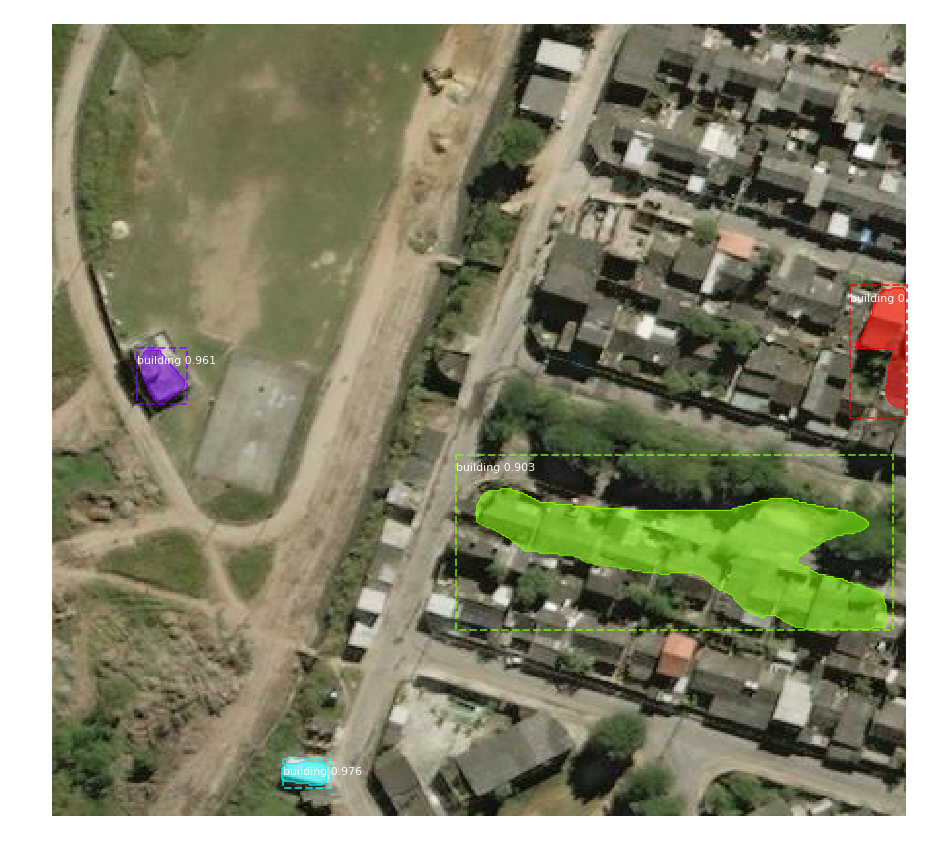

In [6]:
file_names = next(os.walk(IMAGE_DIR))[2]
random_image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

predictions = model.detect([random_image]*config.BATCH_SIZE, verbose=1) # We are replicating the same image to fill up the batch_size

p = predictions[0]
visualize.display_instances(random_image, p['rois'], p['masks'], p['class_ids'], 
                            class_names, p['scores'])

# Author
Sharada Mohanty [sharada.mohanty@epfl.ch](sharada.mohanty@epfl.ch)